In [1]:
from numpy import sin, cos, pi, array
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import math


metadata = dict(title='Rotating Bot', artist='Pete Florence',
        comment='Rotate time')
writer = animation.AVConvWriter(fps=20, metadata=metadata, bitrate=5000)


# constant velocity
v = 1

def derivs(state, t):

    dqdt = np.zeros_like(state)
    
    u = np.cos(state[2])
    
    dqdt[0] = 0 # rotating laser bot can't move
    
    dqdt[1] = 0 # rotating laser bot can't move

    dqdt[2] = sin(t) # constant for now, but later will be u

    return dqdt

# create a time array from 0...30 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 5, dt)

# initial positions
# x and y are position of origin.  We move the origin, not the plane, so that the plane stays in the same spot in the plot.
# psi is yaw, and psidot is yawdot of plane
x = 0.0
y = 0.0
psi = -10.0

rad = pi/180.0

# initial state
state = np.array([x, y, psi*rad])

print "integrating..."
# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)
print "done"

xworld = y[:,0]
yworld = y[:,1]
psiworld = y[:,2]

from ObstacleField import ObstacleField
from Obstacle import Obstacle

obsField = ObstacleField()
obsField.randomField(M=7)
for i in obsField.ObstaclesList:
    i.computeTraj(psiworld,xworld,yworld)

integrating...
done


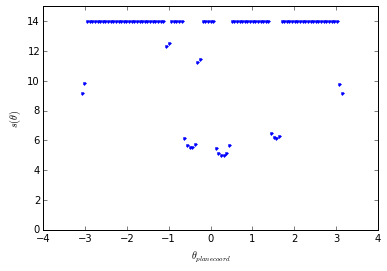

In [2]:
# Add laser
from LineCircleIntersect import intersect
laserLines = []
D = 100 # Number of discrete data points from laser
laseAngles = np.linspace(-math.pi,math.pi,D+1)[0:D]

#S_max
S_maxdist = 14
S_max_t = np.linspace(-math.pi,math.pi,100)
S_max_x = S_maxdist*np.cos(S_max_t)
S_max_y = S_maxdist*np.sin(S_max_t)

xlist = []
ylist = []

laserDepths = laseAngles * 0.0


# Find laser depths at a certain point in time
# Need to not have this code copied
i = 0
for lasenum in range(len(laseAngles)):

    x_laser_endpoint = S_maxdist*math.cos(laseAngles[lasenum])
    y_laser_endpoint = S_maxdist*math.sin(laseAngles[lasenum])

    origin = np.array((0,0))
    laser_endpoint = np.array((x_laser_endpoint,y_laser_endpoint))
    for obs in obsField.ObstaclesList:
        Q = np.array((obs.xtraj[i],obs.ytraj[i]))
        r = obs.radius
        _, pt = intersect(origin,laser_endpoint,Q,r)
        if pt is not None:
            if (pt[0]**2 + pt[1]**2 < x_laser_endpoint**2 + y_laser_endpoint**2):
                x_laser_endpoint = pt[0]
                y_laser_endpoint = pt[1]

    depth = math.sqrt(x_laser_endpoint**2 + y_laser_endpoint**2)
    laserDepths[lasenum] = depth

 
%matplotlib inline
from coordTransforms import transformStandardPolarTheta_to_PlaneTheta
laseAngles2 = laseAngles * 0
for i in range(len(laseAngles)):
    laseAngles2[i] = transformStandardPolarTheta_to_PlaneTheta(laseAngles[i])

plt.plot(laseAngles2,laserDepths,'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis([-4, 4, 0, 15])
plt.show()

import csv
with open('laserdata.csv', 'wb') as csvfile:
    laserwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(laserDepths)):
        laserwriter.writerow([laseAngles2[i], laserDepths[i]])

In [3]:
import os
os.system("rm bot.mp4")
%matplotlib qt
plt.rcParams['figure.figsize'] = 10, 10
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-15, 15), ylim=(-15, 15))
#ax = fig.add_subplot(121, autoscale_on=False, xlim=(-4, 4), ylim=(0, 16))
#ax.grid()

im = plt.imread('bot.png')
newax = fig.add_axes([0.477, 0.46, 0.07, 0.1], anchor='SW')
newax.imshow(im)
newax.axis('off')
ax.set_aspect('equal', 'datalim')
     
S_max, = ax.plot([], [], '--' , lw=1, color='red')   
obstacles, = ax.plot([], [], 'o', markersize=35, lw=2, color='gray')
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

for index in range(D):
    lobj = ax.plot([],[],'-',lw=0.5,color='red')[0]
    laserLines.append(lobj)

def init():
    S_max.set_data([], [])
    obstacles.set_data([], [])
    time_text.set_text('')
    
    for line in laserLines:
        line.set_data([],[])
    
    return obstacles, time_text, laserLines

def animate(i):
    
    # Draw the maximum sensor horizon
    S_max.set_data(S_max_x,S_max_y)
    
    
    # Draw the obstacles as just a bunch of points
    
    all_obs_x = []
    all_obs_y = []
    
    for obs in obsField.ObstaclesList:
        all_obs_x.append(obs.xtraj[i]) #+ obs.plotX) put back in this to plot little points around the circle
        all_obs_y.append(obs.ytraj[i]) #+ obs.plotY)
    
    #all_obs_x = [x_obj1[i], x_obj2[i]]
    #all_obs_y = [y_obj1[i], y_obj2[i]]
    obstacles.set_data(all_obs_x, all_obs_y)
    
    # Draw in the time
    time_text.set_text(time_template%(i*dt))
    
    xlist = []
    ylist = []
    # Draw the laser intersecting obstacles
    for lasenum in range(len(laseAngles)):

        x_laser_endpoint = S_maxdist*math.cos(laseAngles[lasenum])
        y_laser_endpoint = S_maxdist*math.sin(laseAngles[lasenum])
        
        origin = np.array((0,0))
        laser_endpoint = np.array((x_laser_endpoint,y_laser_endpoint))
        for obs in obsField.ObstaclesList:
            Q = np.array((obs.xtraj[i],obs.ytraj[i]))
            r = obs.radius
            _, pt = intersect(origin,laser_endpoint,Q,r)
            if pt is not None:
                if (pt[0]**2 + pt[1]**2 < x_laser_endpoint**2 + y_laser_endpoint**2):
                    x_laser_endpoint = pt[0]
                    y_laser_endpoint = pt[1]
        
        xlist.append([[0,x_laser_endpoint]])
        ylist.append([[0,y_laser_endpoint]])
  

    for lnum,line in enumerate(laserLines):
        line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 

    return obstacles, time_text, laserLines

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
    interval=20, blit=False, init_func=init)
#ani.save('bot.mp4', fps=20, bitrate=5000, codec="h264", writer=writer)
plt.show()

In [5]:

os.system("rm bot_h264.mp4")
os.system("avconv -i bot.mp4 -c:v h264 -c:a copy bot_h264.mp4")

0

In [ ]:
import os
import io
import base64
from IPython.display import HTML

video = io.open('/Users/pflomacpro/GeometricPDEs/_RotatingBot/bot_h264.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))